In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

from sklearn.datasets import load_iris
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
np.random.seed(121)
tf.random.set_seed(121)

## 데이터 확인

In [3]:
train = pd.read_csv('../ML/titanic/train.csv')
test = pd.read_csv('../ML/titanic/test.csv')

In [4]:
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## ID 제거, 결측 확인

In [5]:
train.drop('PassengerId', axis=1, inplace=True)
test.drop('PassengerId', axis=1, inplace=True)

In [6]:
train_test = train.append(test)
nan_dict = {"CNT":train_test.isna().sum(),
            "RATE": train_test.isna().sum()/train.shape[0] *100
}
nan_df = pd.DataFrame(nan_dict)
print(nan_df[nan_df["RATE"]>0].sort_values("CNT", ascending=False))
# Fare: fillna 0
# Age: group by name_title fill na mean
# Survived:

# Cabin: 삭제
# Embarked: fillna mode 

           CNT        RATE
Cabin     1014  113.804714
Survived   418   46.913580
Age        263   29.517396
Embarked     2    0.224467
Fare         1    0.112233


In [7]:
train["Fare"].fillna(0, inplace=True)
test["Fare"].fillna(0, inplace=True)

## EDA

### Name_title

In [8]:
# object type: Name, Sex, Ticket, Cabin, Embarked

In [9]:
train['Name_title'] = train['Name'].str.extract(' ([A-Za-z]+)\.')
test['Name_title'] = test['Name'].str.extract(' ([A-Za-z]+)\.')
print(test['Name_title'].unique())
print(train['Name_title'].unique())

['Mr' 'Mrs' 'Miss' 'Master' 'Ms' 'Col' 'Rev' 'Dr' 'Dona']
['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'Countess' 'Jonkheer']


In [10]:
name_title_dict = {
'Mr':1,
'Mrs':2, 'Mme':2,
'Miss':3, 'Lady':3, 'Ms' :3,'Mlle':3,
'Master':4 ,
    'Don':5 , 'Dona':5, 'Rev':6 , 'Dr':7 , 'Major':8 ,
 'Sir':9, 'Col':10, 'Capt':11, 'Countess':12, 'Jonkheer':13
}
train['Name_title'] = train['Name_title'].map(name_title_dict)
test['Name_title'] = test['Name_title'].map(name_title_dict)
print(train['Name_title'].head())

0    1
1    2
2    3
3    2
4    1
Name: Name_title, dtype: int64


In [11]:
train.drop(['Name'], axis=1, inplace=True)
test.drop(['Name'], axis=1, inplace=True)

### Sex

In [12]:
train['Sex'] = train['Sex'].replace(['female','male'],[0,1])
test['Sex'] = test['Sex'].replace(['female','male'],[0,1])

### Drop Ticket, Cabin

In [13]:
train.drop(['Ticket', 'Cabin'], axis=1, inplace=True)
test.drop(['Ticket', 'Cabin'], axis=1, inplace=True)

### Labeling Embarked

In [14]:
mode_value = train["Embarked"].mode()
train["Embarked"].fillna(mode_value[0], inplace=True)
test["Embarked"].fillna(mode_value[0], inplace=True)

In [15]:
label_encoder = LabelEncoder()
train["Embarked"] = label_encoder.fit_transform(train["Embarked"])
test["Embarked"] = label_encoder.transform(test["Embarked"])

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    int64  
 3   Age         714 non-null    float64
 4   SibSp       891 non-null    int64  
 5   Parch       891 non-null    int64  
 6   Fare        891 non-null    float64
 7   Embarked    891 non-null    int32  
 8   Name_title  891 non-null    int64  
dtypes: float64(2), int32(1), int64(6)
memory usage: 59.3 KB


### FillNA Age

In [17]:
train["Age"].fillna(train.groupby("Name_title")["Age"].transform("mean"), inplace=True)
test["Age"].fillna(test.groupby("Name_title")["Age"].transform("mean"), inplace=True)
print(train["Age"].unique())

[22.         38.         26.         35.         32.36809045 54.
  2.         27.         14.          4.         58.         20.
 39.         55.         31.         35.78899083 34.         15.
 28.          8.         19.         22.02       40.         66.
 42.         21.         18.          3.          7.         49.
 29.         65.         28.5         5.         11.         45.
  4.57416667 17.         32.         16.         25.          0.83
 30.         33.         23.         24.         46.         59.
 71.         37.         47.         14.5        70.5        32.5
 12.          9.         36.5        51.         55.5        40.5
 44.          1.         61.         56.         50.         36.
 45.5        20.5        62.         41.         52.         63.
 23.5         0.92       43.         60.         10.         64.
 13.         48.          0.75       53.         57.         80.
 70.         24.5         6.          0.67       30.5         0.42
 34.5        74.   

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    int64  
 3   Age         891 non-null    float64
 4   SibSp       891 non-null    int64  
 5   Parch       891 non-null    int64  
 6   Fare        891 non-null    float64
 7   Embarked    891 non-null    int32  
 8   Name_title  891 non-null    int64  
dtypes: float64(2), int32(1), int64(6)
memory usage: 59.3 KB


## Modeling

In [20]:
X = train.drop('Survived', axis = 1)
y = train['Survived']

In [21]:
# y_oh = to_categorical(y) # 원핫 인코딩 001 010 100

In [22]:
model = Sequential()
model.add(Dense(units=128, input_dim = 8, activation='relu'))
model.add(Dense(units=64,                activation='relu'))
model.add(Dense(units=16,                activation='relu'))
model.add(Dense(units=1,                activation='sigmoid')) # multi
# model.add(Dense(units=2,                activation='softmax')) # binary

In [23]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# sparce_crossentroby : 원핫 인코딩 없이 할 때, 0, 1, 2로 분류 

In [24]:
estop = EarlyStopping(monitor='val_accuracy', patience=4)

In [25]:
res = model.fit(X, y, epochs=200, 
          callbacks=[estop],
          validation_split=0.2, verbose=1)

Epoch 1/200
23/23 [==============================] - 0s 7ms/step - loss: 0.7243 - accuracy: 0.5786 - val_loss: 0.5744 - val_accuracy: 0.6760
Epoch 2/200
23/23 [==============================] - 0s 2ms/step - loss: 0.6170 - accuracy: 0.6867 - val_loss: 0.5439 - val_accuracy: 0.7374
Epoch 3/200
23/23 [==============================] - 0s 2ms/step - loss: 0.5656 - accuracy: 0.6961 - val_loss: 0.4938 - val_accuracy: 0.7598
Epoch 4/200
23/23 [==============================] - 0s 2ms/step - loss: 0.6248 - accuracy: 0.6667 - val_loss: 0.4783 - val_accuracy: 0.7765
Epoch 5/200
23/23 [==============================] - 0s 2ms/step - loss: 0.5720 - accuracy: 0.7191 - val_loss: 0.4790 - val_accuracy: 0.8045
Epoch 6/200
23/23 [==============================] - 0s 2ms/step - loss: 0.5822 - accuracy: 0.7030 - val_loss: 0.4605 - val_accuracy: 0.7933
Epoch 7/200
23/23 [==============================] - 0s 2ms/step - loss: 0.5621 - accuracy: 0.7264 - val_loss: 0.4859 - val_accuracy: 0.7598
Epoch 8/200
2

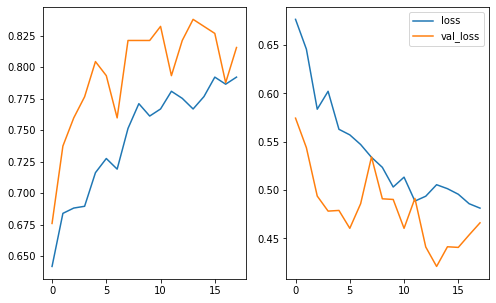

In [26]:
plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
plt.plot(res.history['accuracy'], label='accuracy')
plt.plot(res.history['val_accuracy'], label='val_accuracy')

plt.subplot(1,2,2)
plt.plot(res.history['loss'], label='loss')
plt.plot(res.history['val_loss'], label='val_loss')

plt.legend()
plt.show()